In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import polars as pl
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import pickle
import os
import sqlite3
from itertools import chain
import matplotlib.dates as mdates

In [3]:
df = pl.read_parquet('full_enc_search.parquet')
cl = np.load('data/input/relevant_clients.npy')
df = df.filter(pl.col('client_id').is_in(set(cl)))
df.head()
del cl

In [4]:
df.select(['timestamp_visit', 'timestamp_rm', 'timestamp_buy', 'timestamp_search', 'timestamp_add']).with_columns([pl.col(c).list.min() for c in ['timestamp_visit', 'timestamp_rm', 'timestamp_buy', 'timestamp_search', 'timestamp_add']]).min()

timestamp_visit,timestamp_rm,timestamp_buy,timestamp_search,timestamp_add
datetime[ns],datetime[ns],datetime[ns],datetime[ns],datetime[ns]
2022-06-23 00:10:00,2022-06-23 00:12:25,2022-06-23 00:12:15,2022-06-23 00:10:50,2022-06-23 00:10:20


In [5]:
df.select(['timestamp_visit', 'timestamp_rm', 'timestamp_buy', 'timestamp_search', 'timestamp_add']).with_columns([pl.col(c).list.max() for c in ['timestamp_visit', 'timestamp_rm', 'timestamp_buy', 'timestamp_search', 'timestamp_add']]).max()

timestamp_visit,timestamp_rm,timestamp_buy,timestamp_search,timestamp_add
datetime[ns],datetime[ns],datetime[ns],datetime[ns],datetime[ns]
2022-11-09 23:59:59,2022-11-09 23:59:50,2022-11-09 23:59:35,2022-11-09 23:59:59,2022-11-09 23:59:55


In [6]:
buy = np.concatenate(list(map(lambda x: x[0], df.filter(pl.col('ts_proportional_buy').is_not_null()).select('ts_proportional_buy').to_numpy().tolist())))
add = np.concatenate(list(map(lambda x: x[0], df.filter(pl.col('ts_proportional_add').is_not_null()).select('ts_proportional_add').to_numpy().tolist())))
rm = np.concatenate(list(map(lambda x: x[0], df.filter(pl.col('ts_proportional_rm').is_not_null()).select('ts_proportional_rm').to_numpy().tolist())))
sea = np.concatenate(list(map(lambda x: x[0], df.filter(pl.col('ts_proportional_visit').is_not_null()).select('ts_proportional_visit').to_numpy().tolist())))
vis = np.concatenate(list(map(lambda x: x[0], df.filter(pl.col('ts_proportional_search').is_not_null()).select('ts_proportional_search').to_numpy().tolist())))

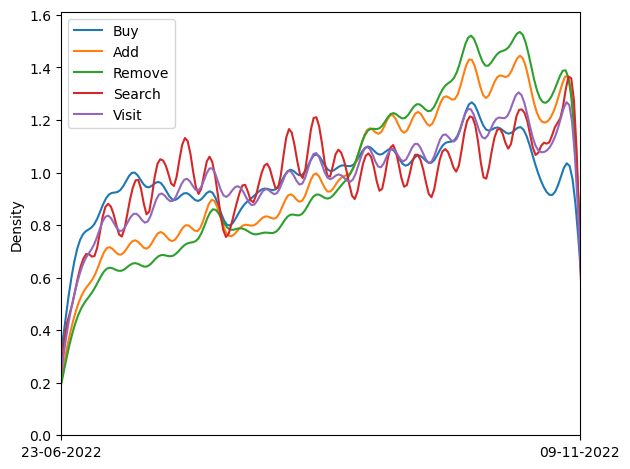

In [7]:
sns.kdeplot(x=buy, label='Buy')
sns.kdeplot(x=add, label='Add')
sns.kdeplot(x=rm, label='Remove')
sns.kdeplot(x=sea, label='Search')
sns.kdeplot(x=vis, label='Visit')

plt.legend()

# Format the x-axis as dates if they are datetime
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

# Set start and end date for x-axis ticks
start_date = '23-06-2022'
end_date = '09-11-2022'
plt.xlim([start_date, end_date])

# Rotate x-tick labels if needed
#plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("time_kde.pdf")
plt.show()

In [8]:
del buy
del add
del rm
del sea
del vis

In [9]:
df = pl.read_parquet('enc2_fast_cat_price.parquet')

df = df.with_columns(
    pl.col('visits').fill_null(0),
    pl.col('adds').fill_null(0),
    pl.col('rms').fill_null(0),
    pl.col('searchs').fill_null(0),
    pl.col('buys').fill_null(0),
    pl.col('kde_visits').fill_null([0] * 11),
    pl.col('kde_adds').fill_null([0] * 11),
    pl.col('kde_rms').fill_null([0] * 11),
    pl.col('kde_searchs').fill_null([0] * 11),
    pl.col('kde_buys').fill_null([0] * 11),
    pl.col('url_visit').fill_null([]),
    pl.col('sku_add').fill_null([]),
    pl.col('sku_rm').fill_null([]),
    pl.col('query_search').fill_null([0] * 64),
    pl.col('sku_buy').fill_null([]),
    pl.col('sku_add_cat').fill_null([]),
    pl.col('sku_rm_cat').fill_null([]),
    pl.col('sku_buy_cat').fill_null([]),
    pl.col('sku_add_price').fill_null([]),
    pl.col('sku_rm_price').fill_null([]),
    pl.col('sku_buy_price').fill_null([])
)

In [10]:
df = df.with_columns(pl.col('sku_buy_price').map_elements(lambda x: 0 if len(x) == 0 else sum(x)/len(x), return_dtype=pl.Float64).alias('price_buy'),
                    pl.col('sku_rm_price').map_elements(lambda x: 0 if len(x) == 0 else sum(x)/len(x), return_dtype=pl.Float64).alias('price_rm'),
                    pl.col('sku_add_price').map_elements(lambda x: 0 if len(x) == 0 else sum(x)/len(x), return_dtype=pl.Float64).alias('price_add'))

In [11]:
points = np.arange(11) / 10
masses = {}
for c in ['kde_buys', 'kde_visits', 'kde_adds', 'kde_rms', 'kde_searchs']:
    alias = 'mass_' + c.split('_')[1]
    density = np.asarray(df[c].to_list())
    mass = np.sum(density * points, axis=1) / np.clip(np.sum(density, axis=1), a_min=1e-8, a_max=None)
    masses[alias] = mass

df_mass = pl.DataFrame(data=masses)

df = pl.concat([df, df_mass], how='horizontal')

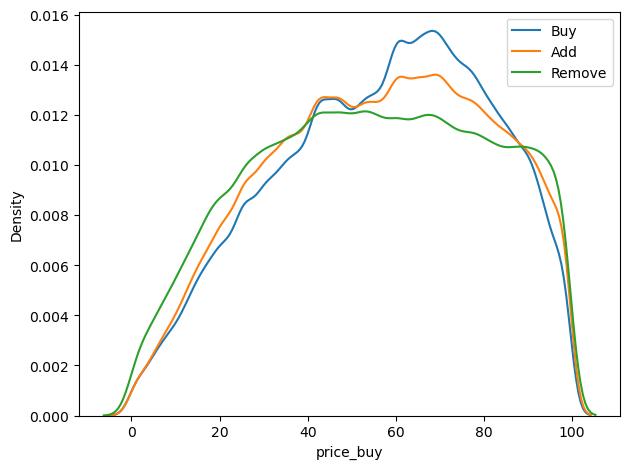

In [26]:
sns.kdeplot(df.filter(pl.col('buys') > 0).select('price_buy'), x='price_buy', label='Buy')
sns.kdeplot(df.filter(pl.col('adds') > 0).select('price_add'), x='price_add', label='Add')
sns.kdeplot(df.filter(pl.col('rms') > 0).select('price_rm'), x='price_rm', label='Remove')

plt.legend()
plt.tight_layout()
plt.savefig("price_kde.pdf")

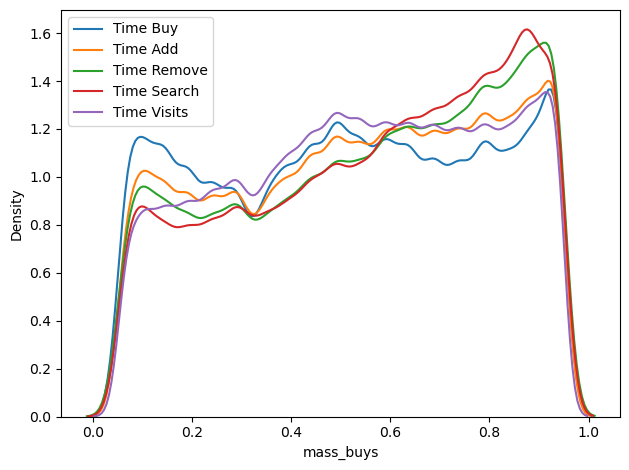

In [28]:
sns.kdeplot(df.filter(pl.col('mass_buys') > 0).select('mass_buys'), x='mass_buys', label='Time Buy')
sns.kdeplot(df.filter(pl.col('mass_adds') > 0).select('mass_adds'), x='mass_adds', label='Time Add')
sns.kdeplot(df.filter(pl.col('mass_rms') > 0).select('mass_rms'), x='mass_rms', label='Time Remove')
sns.kdeplot(df.filter(pl.col('mass_searchs') > 0).select('mass_searchs'), x='mass_searchs', label='Time Search')
sns.kdeplot(df.filter(pl.col('mass_visits') > 0).select('mass_visits'), x='mass_visits', label='Time Visits')
plt.legend()
plt.tight_layout()
plt.savefig("mass_user_kde.pdf")

<Axes: >

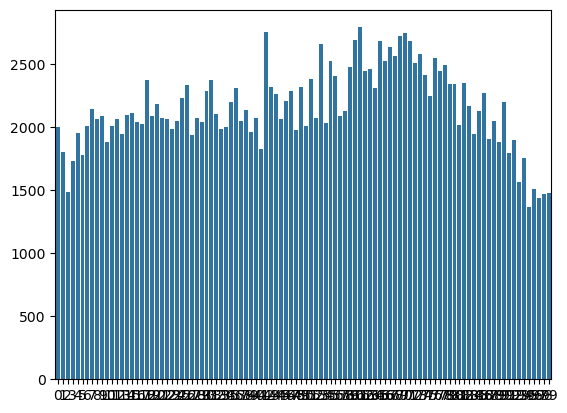

In [29]:
df_plot = df.filter(pl.col('buys') > 0).select('sku_buy_price').to_pandas().sample(100000, random_state=42)
prices = np.concatenate(df_plot.to_numpy().tolist(), axis=1)[0, :].tolist()
count = [0] * 100
for p in prices:
    count[p] += 1
sns.barplot(x=list(range(100)), y=count)

In [30]:
embs = np.load('Models/EMA_OneCycleLarge/embeddings.npy')

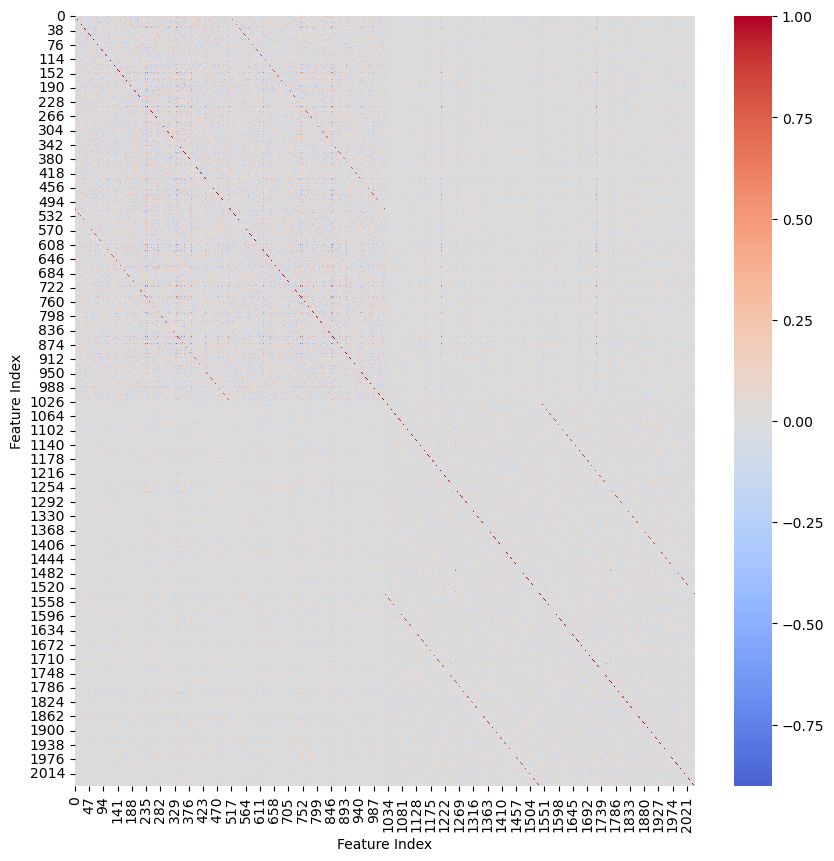

In [31]:
corr_matrix = np.corrcoef(embs[:100000,:], rowvar=False)

# Optional: Clip for display (helps with noisy values)
corr_matrix = np.clip(corr_matrix, -1, 1)

# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
#plt.title("Column-wise Correlation Heatmap")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.savefig("Features_coor.pdf")
plt.show()

In [32]:
coor = []
for i in tqdm(range(2048)):
    coor.append(spearmanr(embs[:, i], df_full['buys', 'adds', 'rms', 'searchs', 'visits']).statistic[0,1:])

  0%|          | 0/2048 [00:00<?, ?it/s]

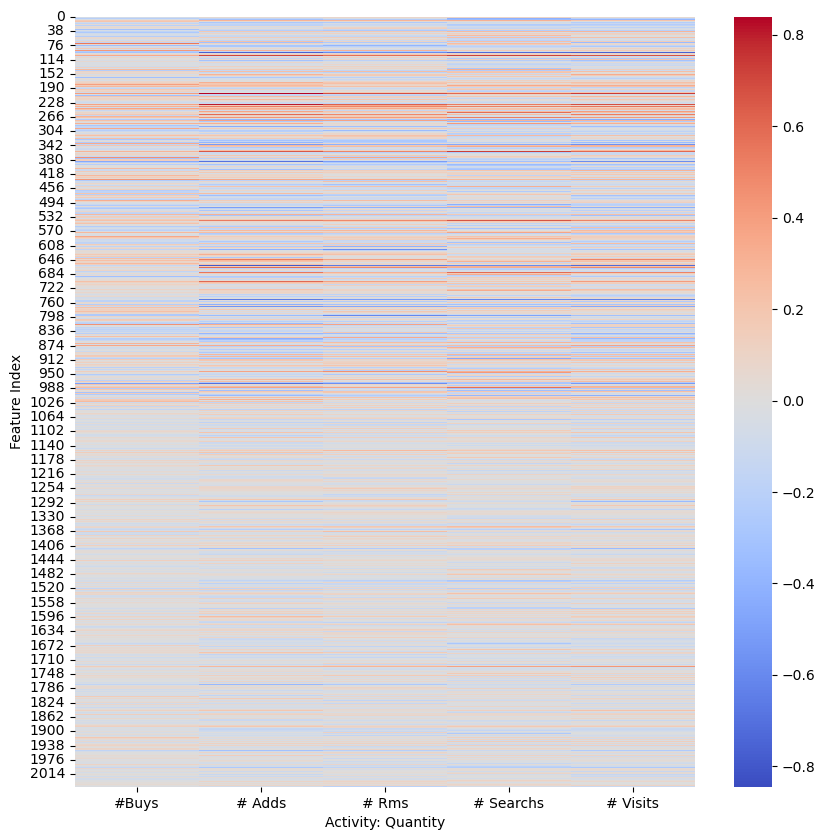

In [38]:
plt.figure(figsize=(10, 10))
sns.heatmap(coor, cmap='coolwarm', center=0, xticklabels=['#Buys', '# Adds', '# Rms', '# Searchs', '# Visits'])
#plt.title("Column-wise Correlation Heatmap")
plt.xlabel("Activity: Quantity")
plt.ylabel("Feature Index")
plt.savefig("logs_coor.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [34]:
coor_mass = []
for i in tqdm(range(2048)):
    coor_mass.append(spearmanr(embs[:, i], df_full['mass_buys', 'mass_adds', 'mass_rms', 'mass_searchs', 'mass_visits']).statistic[0,1:])

  0%|          | 0/2048 [00:00<?, ?it/s]

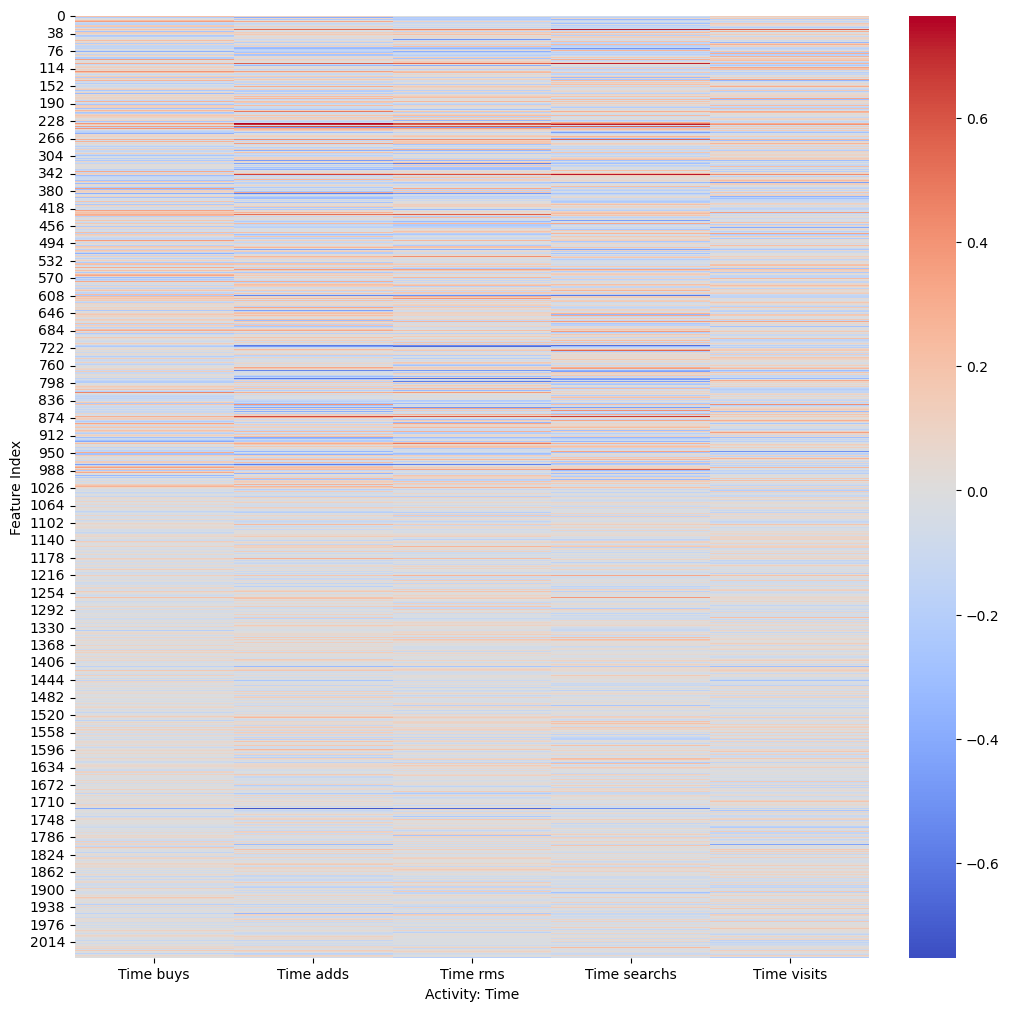

In [41]:
plt.figure(figsize=(10, 10), constrained_layout=True)
sns.heatmap(coor_mass, cmap='coolwarm', center=0, xticklabels=['Time buys', 'Time adds', 'Time rms', 'Time searchs', 'Time visits'])
#plt.title("Column-wise Correlation Heatmap")
plt.xlabel("Activity: Time")
plt.ylabel("Feature Index")
plt.savefig("logs_time_coor.pdf", bbox_inches='tight', pad_inches=0)

plt.show()